In [76]:
from scipy import stats
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
L21 = 0.1
L31 = -0.6
L41 = -0.7
L51 = 0
L61 = 0.4
L71 = 0.2
L32 = 0
L42 = -0.1
L52 = 0.4
L62 = 0.1
L72 = 0.1
L43 = 0.2
L53 = -0.4
L63 = 0.6
L73 = 0.01
L54 = 0.4
L64 = 0.1
L74 = -0.3
L65 = 0.3
L75 = 0.5
L76 = 0.2

In [4]:
L11 = 1

if 1-L21**2 >=0:
    L22 = np.sqrt(1-L21**2)
else:
    raise ValueError('1-L21**2 must be >=0')

if 1-L31**2-L32**2 >=0:
    L33 = np.sqrt(1-L31**2-L32**2)
else:
    raise ValueError('1-L31**2-L32**2 must be >=0')

if 1-L41**2-L42**2-L43**2 >=0:
    L44 = np.sqrt(1-L41**2-L42**2-L43**2)
else:
    raise ValueError('1-L41**2-L42**2-L43**2 must be >=0')

if 1-L51**2-L52**2-L53**2-L54**2 >=0:
    L55 = np.sqrt(1-L51**2-L52**2-L53**2-L54**2)
else:
    raise ValueError('1-L51**2-L52**2-L53**2-L54**2 must be >=0')

if 1-L61**2-L62**2-L63**2-L64**2-L65**2 >=0:
    L66 = np.sqrt(1-L61**2-L62**2-L63**2-L64**2-L65**2)
else:
    raise ValueError('1-L61**2-L62**2-L63**2-L64**2-L65**2 must be >=0')

if 1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 >=0:
    L77 = np.sqrt(1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2)
else:
    raise ValueError('1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 must be >=0')

In [5]:
L = [[L11, 0, 0, 0, 0, 0, 0],
     [L21, L22, 0, 0, 0, 0, 0],
     [L31, L32, L33, 0, 0, 0, 0],
     [L41, L42, L43, L44, 0, 0, 0],
     [L51, L52, L53, L54, L55, 0, 0],
     [L61, L62, L63, L64, L65, L66, 0],
     [L71, L72, L73, L74, L75, L76, L77]]

In [6]:
covmat_Z = np.dot(L, np.transpose(L))

# The covariance (=correlation here) matrix must be non-singular and positive semi-definite: verification
if not np.all(np.linalg.eigvals(covmat_Z) >= 0):
    raise ValueError('The covariance matrix is not positive semi-definite')
if round(np.linalg.det(covmat_Z), 6) == 0:
    raise ValueError('The covariance matrix is singular')
# All entries must be in [-1,1]
if not np.all(np.abs(covmat_Z <= 1)):
    raise ValueError('All entries of the correlation matrix must be in [-1,1]')

In [7]:
mvnorm = stats.multivariate_normal(mean=np.zeros(covmat_Z.shape[0]), cov=covmat_Z)

m1 = stats.norm(2,0.6)
m2 = stats.norm(0.2,0.3)
m3 = stats.norm(-0.3,2)
m4 = stats.norm(0.7,0.4)
m5 = stats.uniform()
m6 = stats.uniform()
m7 = stats.uniform()

p_a = 0.3
tau_a = 1 - p_a

p_b = 0.9
tau_b = 1-p_b

p_y = 0.2
tau_y = 1 - p_y

In [8]:
!mkdir bias_data

datasets=[]
for i in tqdm(range(100)):
    z = mvnorm.rvs(100000)
    u = stats.norm.cdf(z)
    x1 = m1.ppf(u[:, 0])
    x2 = m2.ppf(u[:, 1])
    x3 = m3.ppf(u[:, 2])
    x4 = m4.ppf(u[:, 3])
    x5 = m5.ppf(u[:, 4])
    x6 = m6.ppf(u[:, 5])
    x7 = m7.ppf(u[:, 6])
    a = np.zeros(len(x5), dtype=int)
    a[x5 >= tau_a] = 1
    b = np.zeros(len(x6), dtype=int)
    b[x6 >= tau_b] = 1
    y = np.zeros(len(x7), dtype=int)
    y[x7 >= tau_y] = 1
    data = pd.DataFrame({'X1':x1, 'X2':x2, 'X3':x3, 'X4':x4, 'A':a, 'B':b, 'Y':y})
    data.to_csv('bias_data/synthetic_data_v2010_' + str(i) + '.csv', index=False)
    datasets.append(data)

mkdir: cannot create directory ‘bias_data’: File exists


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


In [9]:
datasets[0]

,X1,X2,X3,X4,A,B,Y
0,2.535299,0.316284,-0.089167,0.056767,0,1,0
1,1.971813,0.039817,0.559972,0.622804,0,0,0
2,2.127474,0.656362,-0.415897,0.372351,0,1,0
3,2.301446,0.253213,-2.627403,1.118683,1,1,0
4,2.218220,0.335621,-0.223675,-0.036342,0,1,1
...,...,...,...,...,...,...,...
99995,2.426706,0.427846,-0.308253,0.274809,0,1,0
99996,1.520573,-0.117834,0.919207,1.046309,0,1,0
99997,1.219519,0.146581,0.499014,1.394656,0,1,0
99998,2.584946,0.333758,-2.596027,-0.103257,0,1,0


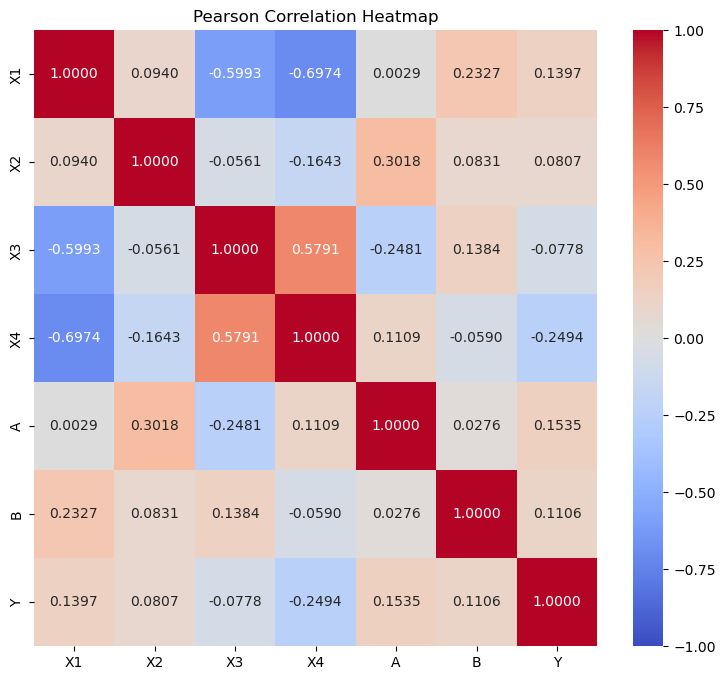

In [10]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim-2)
        self.relu = nn.ReLU()
    def forward(self, x):
#         return self.relu(self.fc1(x))
        return self.fc1(x)

In [12]:
class Predictor(nn.Module):
    def __init__(self, input_dim):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [13]:
class Adversary(nn.Module):
    def __init__(self, input_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['X1', 'X2', 'X3', 'X4', 'A', 'B']].values, dtype=torch.float32)
#         self.A = torch.tensor(dataframe[['A']].values, dtype=torch.float32)
#         self.B = torch.tensor(dataframe[['B']].values, dtype=torch.float32)
        self.Y = torch.tensor(dataframe[['Y']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
#         return self.X[idx], self.A[idx], self.B[idx], self.Y[idx]
        return self.X[idx], self.Y[idx]

dataset = CustomDataset(datasets[0])
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [15]:
encoder = Encoder(6)
predictor = Predictor(4)
adversaryA = Adversary(4)
adversaryB = Adversary(4)

In [16]:
learning_rate = 0.01

criterion_enc = nn.MSELoss()
criterion_pred = nn.BCELoss()
criterion_advA = nn.BCELoss()
criterion_advB = nn.BCELoss()

optimizer_pred = optim.Adam(predictor.parameters(), lr=learning_rate)
optimizer_advA = optim.Adam(adversaryA.parameters(), lr=learning_rate)
optimizer_advB = optim.Adam(adversaryB.parameters(), lr=learning_rate)
optimizer_enc = optim.Adam(encoder.parameters(), lr=learning_rate)

In [17]:
for a,b in dataloader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([256, 6])
torch.Size([256, 1])


In [18]:
num_epochs = 5
encoder.train()

gradient_norms_enc = []
epochs_enc = []

In [19]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        encoder.zero_grad()
        x_recon = encoder(data)
        lx = criterion_enc(x_recon, data[:,:4])
        lx.backward()

        batch_gradient_norm = 0.0
        for p in encoder.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_enc.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_enc.append(average_gradient_norm)
    epochs_enc.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Recon: {lx.item():.4f}')

Epoch [1/5], Loss Recon: 0.0092
Epoch [2/5], Loss Recon: 0.0020
Epoch [3/5], Loss Recon: 0.0004
Epoch [4/5], Loss Recon: 0.0001
Epoch [5/5], Loss Recon: 0.0000


In [20]:
gradient_norms_enc

[0.2968504212862134,
 0.01983652402622576,
 0.008212798536665167,
 0.004123010228712531,
 0.0019396238693776332]

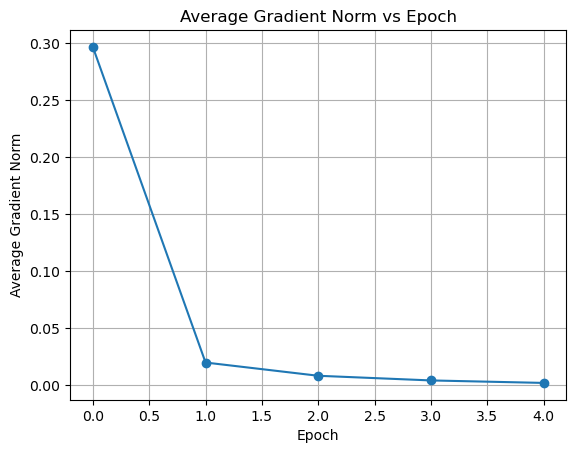

In [21]:
plt.plot(epochs_enc, gradient_norms_enc, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [22]:
# index = 0
# df_original = datasets[index].copy()

# dataset = CustomDataset(df_original)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# encoder_outputs = []
# encoder.eval()
# with torch.no_grad():
#     for batch_X, _ in dataloader:
#         output = encoder(batch_X)
#         encoder_outputs.append(output)
# encoder_outputs = torch.cat(encoder_outputs, dim=0)

# encoder_outputs_np = encoder_outputs.numpy()
# df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

# df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B], axis=1)

# correlation_matrix = df.corr()

# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

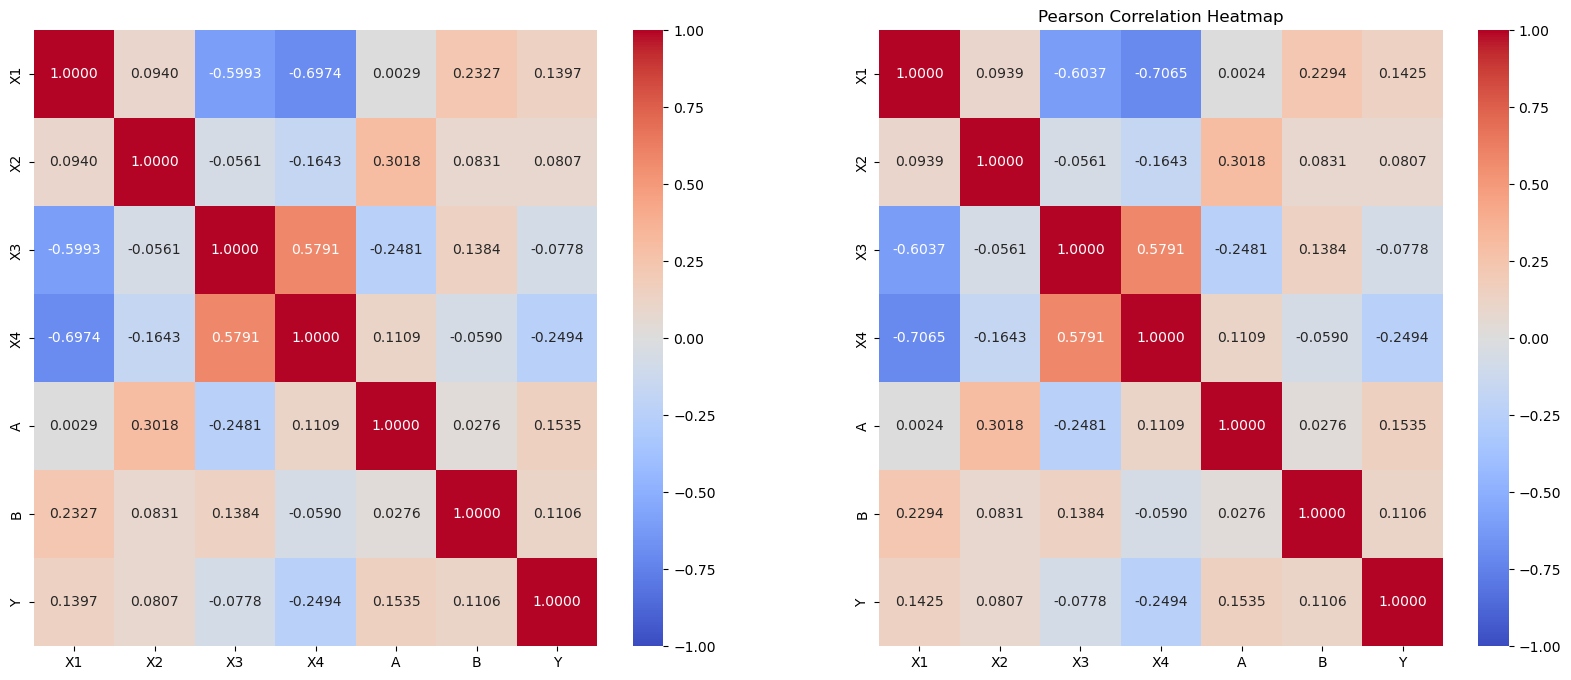

In [23]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [24]:
num_epochs = 30
predictor.train()

gradient_norms_pred = []
epochs_pred = []

In [25]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        predictor.zero_grad()
        x_recon = encoder(data)
        y_pred = predictor(x_recon.detach())
        lp = criterion_pred(y_pred, labels)
        lp.backward()
        
        batch_gradient_norm = 0.0
        for p in predictor.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_pred.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_pred.append(average_gradient_norm)
    epochs_pred.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Pred: {lp.item():.4f}')

Epoch [1/30], Loss Pred: 0.5019
Epoch [2/30], Loss Pred: 0.4807
Epoch [3/30], Loss Pred: 0.4557
Epoch [4/30], Loss Pred: 0.5074
Epoch [5/30], Loss Pred: 0.4492
Epoch [6/30], Loss Pred: 0.4756
Epoch [7/30], Loss Pred: 0.4947
Epoch [8/30], Loss Pred: 0.5225
Epoch [9/30], Loss Pred: 0.4798
Epoch [10/30], Loss Pred: 0.4420
Epoch [11/30], Loss Pred: 0.4880
Epoch [12/30], Loss Pred: 0.5324
Epoch [13/30], Loss Pred: 0.4964
Epoch [14/30], Loss Pred: 0.4772
Epoch [15/30], Loss Pred: 0.4922
Epoch [16/30], Loss Pred: 0.4932
Epoch [17/30], Loss Pred: 0.4419
Epoch [18/30], Loss Pred: 0.3956
Epoch [19/30], Loss Pred: 0.5416
Epoch [20/30], Loss Pred: 0.4854
Epoch [21/30], Loss Pred: 0.5178
Epoch [22/30], Loss Pred: 0.4817
Epoch [23/30], Loss Pred: 0.4928
Epoch [24/30], Loss Pred: 0.4994
Epoch [25/30], Loss Pred: 0.4245
Epoch [26/30], Loss Pred: 0.5120
Epoch [27/30], Loss Pred: 0.4016
Epoch [28/30], Loss Pred: 0.5170
Epoch [29/30], Loss Pred: 0.3740
Epoch [30/30], Loss Pred: 0.4828


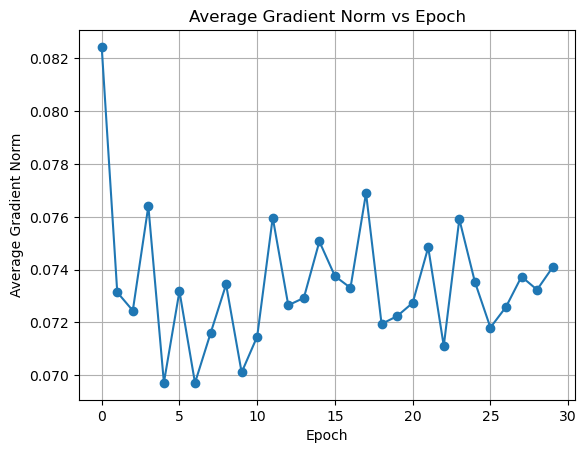

In [26]:
plt.plot(list(range(num_epochs)), gradient_norms_pred, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

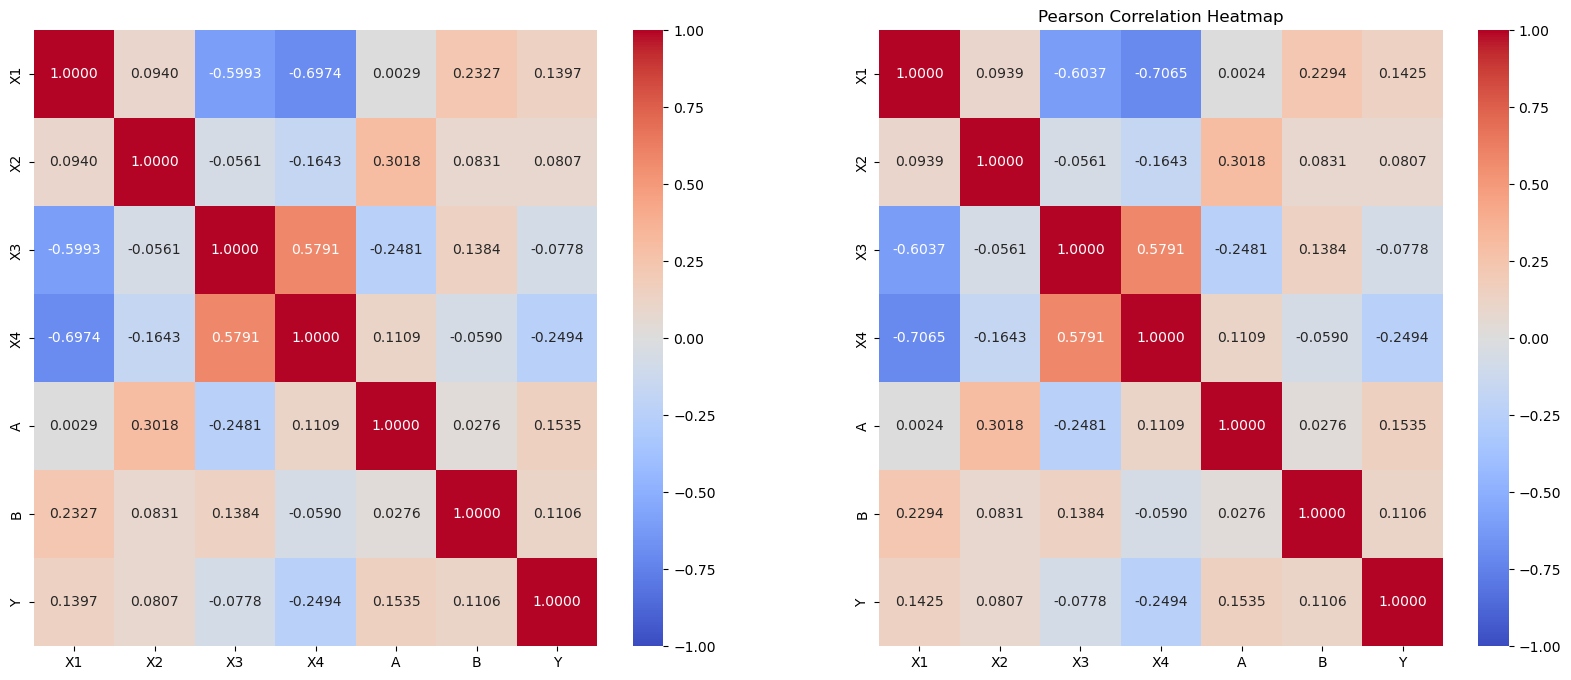

In [27]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [28]:
num_epochs = 30
adversaryA.train()

gradient_norms_advA = []
epochs_advA = []

In [29]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon.detach())
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laA.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advA.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advA.append(average_gradient_norm)
    epochs_advA.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv A: {laA.item():.4f}')

Epoch [1/30], Loss Adv A: 0.5293
Epoch [2/30], Loss Adv A: 0.4372
Epoch [3/30], Loss Adv A: 0.4471
Epoch [4/30], Loss Adv A: 0.4720
Epoch [5/30], Loss Adv A: 0.4549
Epoch [6/30], Loss Adv A: 0.4172
Epoch [7/30], Loss Adv A: 0.3922
Epoch [8/30], Loss Adv A: 0.4076
Epoch [9/30], Loss Adv A: 0.4943
Epoch [10/30], Loss Adv A: 0.3910
Epoch [11/30], Loss Adv A: 0.4455
Epoch [12/30], Loss Adv A: 0.3909
Epoch [13/30], Loss Adv A: 0.4021
Epoch [14/30], Loss Adv A: 0.4729
Epoch [15/30], Loss Adv A: 0.4041
Epoch [16/30], Loss Adv A: 0.4456
Epoch [17/30], Loss Adv A: 0.3966
Epoch [18/30], Loss Adv A: 0.4212
Epoch [19/30], Loss Adv A: 0.5029
Epoch [20/30], Loss Adv A: 0.4012
Epoch [21/30], Loss Adv A: 0.4294
Epoch [22/30], Loss Adv A: 0.5177
Epoch [23/30], Loss Adv A: 0.4627
Epoch [24/30], Loss Adv A: 0.4503
Epoch [25/30], Loss Adv A: 0.4579
Epoch [26/30], Loss Adv A: 0.3956
Epoch [27/30], Loss Adv A: 0.3948
Epoch [28/30], Loss Adv A: 0.5032
Epoch [29/30], Loss Adv A: 0.4922
Epoch [30/30], Loss Adv

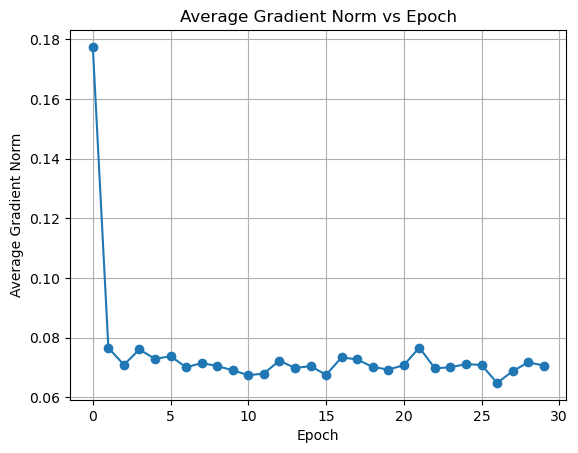

In [30]:
plt.plot(list(range(num_epochs)), gradient_norms_advA, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

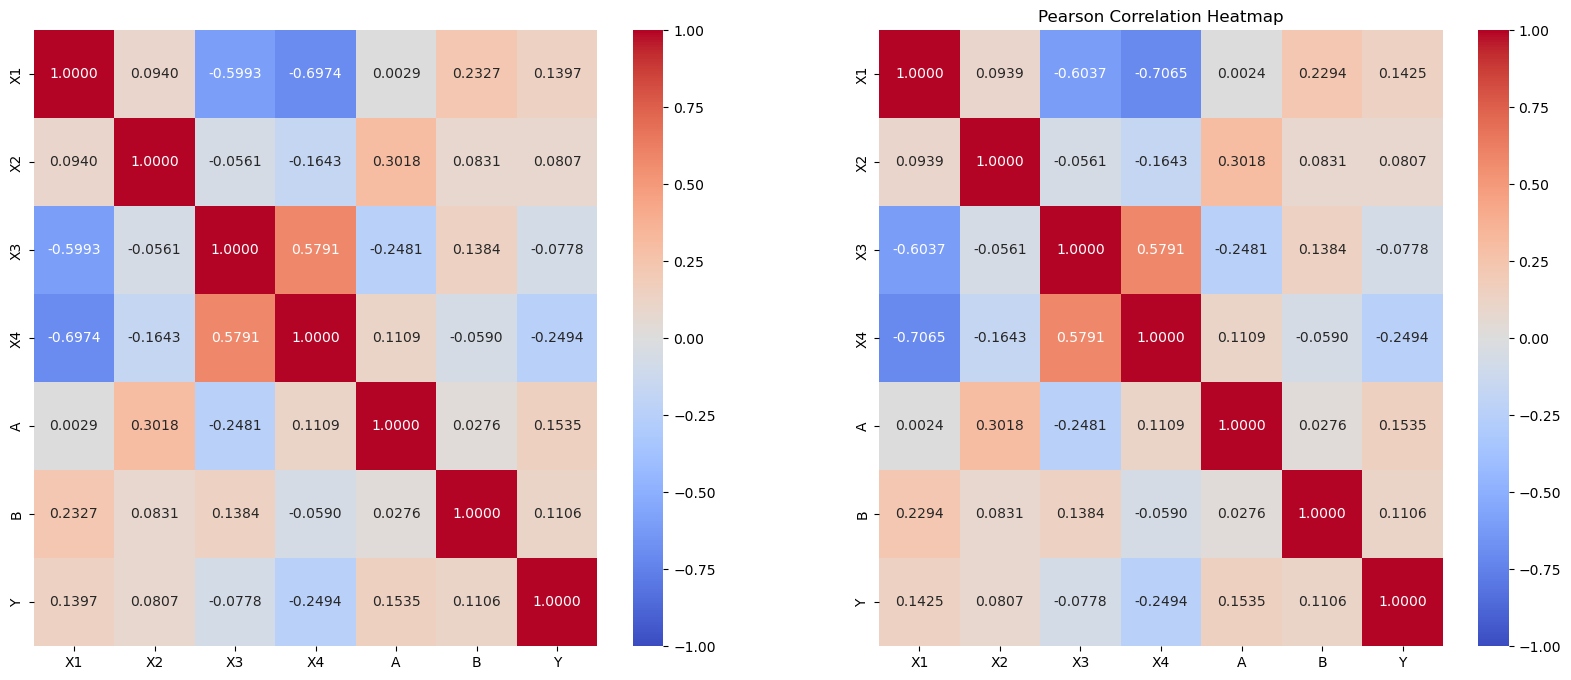

In [31]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [32]:
num_epochs = 30
adversaryB.train()

gradient_norms_advB = []
epochs_advB = []

In [33]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predB = adversaryB(x_recon.detach())
        laB = criterion_advB(adv_predB, data[:,4].view(-1,1).float())
        laB.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advB.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advB.append(average_gradient_norm)
    epochs_advB.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv: {laB.item():.4f}')

Epoch [1/30], Loss Adv: 0.5607
Epoch [2/30], Loss Adv: 0.4308
Epoch [3/30], Loss Adv: 0.4063
Epoch [4/30], Loss Adv: 0.4682
Epoch [5/30], Loss Adv: 0.4351
Epoch [6/30], Loss Adv: 0.4505
Epoch [7/30], Loss Adv: 0.4813
Epoch [8/30], Loss Adv: 0.4255
Epoch [9/30], Loss Adv: 0.4759
Epoch [10/30], Loss Adv: 0.4446
Epoch [11/30], Loss Adv: 0.4837
Epoch [12/30], Loss Adv: 0.5040
Epoch [13/30], Loss Adv: 0.4040
Epoch [14/30], Loss Adv: 0.4505
Epoch [15/30], Loss Adv: 0.4734
Epoch [16/30], Loss Adv: 0.4633
Epoch [17/30], Loss Adv: 0.4005
Epoch [18/30], Loss Adv: 0.4088
Epoch [19/30], Loss Adv: 0.3568
Epoch [20/30], Loss Adv: 0.5127
Epoch [21/30], Loss Adv: 0.4139
Epoch [22/30], Loss Adv: 0.4080
Epoch [23/30], Loss Adv: 0.4655
Epoch [24/30], Loss Adv: 0.4528
Epoch [25/30], Loss Adv: 0.3904
Epoch [26/30], Loss Adv: 0.3987
Epoch [27/30], Loss Adv: 0.4027
Epoch [28/30], Loss Adv: 0.4684
Epoch [29/30], Loss Adv: 0.5049
Epoch [30/30], Loss Adv: 0.5029


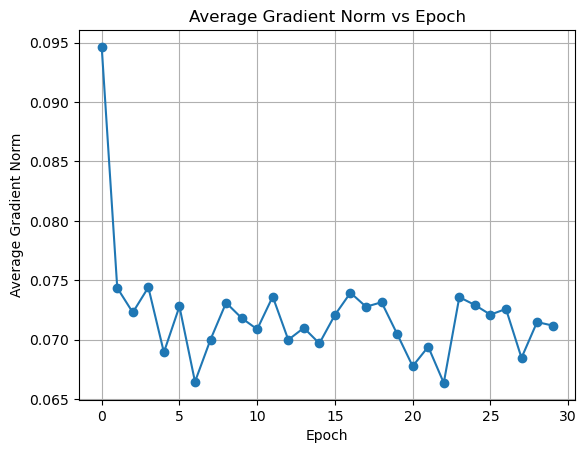

In [34]:
plt.plot(list(range(num_epochs)), gradient_norms_advB, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

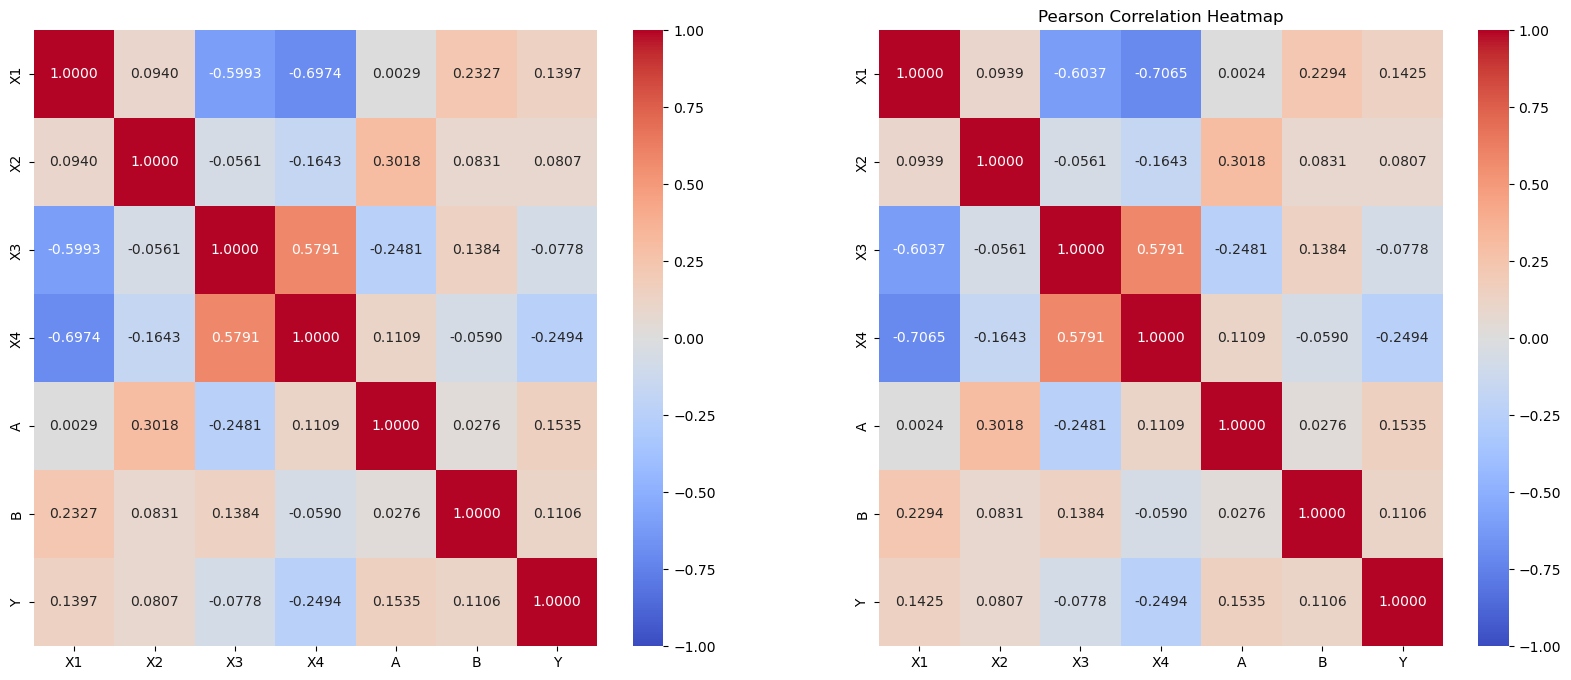

In [35]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [36]:
num_epochs = 50
encoder.train()
predictor.train()
adversaryA.train()
adversaryB.train()

gradient_norms_advA = []
gradient_norms_advB = []
gradient_norms_enc = []
gradient_norms_pred = []
epochs_total = []

In [68]:
for epoch in range(num_epochs):
    
    total_gradient_norm_A = 0.0
    total_gradient_norm_B = 0.0
    total_gradient_norm_enc = 0.0
    total_gradient_norm_pred = 0.0
    num_batches_adv = 0
    num_batches_other = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon)
        adv_predB = adversaryB(x_recon)
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
        laA.backward(retain_graph=True)
        laB.backward()
        
        batch_gradient_norm_A = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
        total_gradient_norm_A += batch_gradient_norm_A

        batch_gradient_norm_B = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
        total_gradient_norm_B += batch_gradient_norm_B

        num_batches_adv += 1

#         torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
#         torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

        optimizer_advA.step()
        optimizer_advB.step()
        
    for data, labels in dataloader: 
        pass
    
    encoder.zero_grad()
    predictor.zero_grad()
    x_recon = encoder(data)
    y_pred = predictor(x_recon)
    adv_predA = adversaryA(x_recon)
    adv_predB = adversaryB(x_recon)

    lx = criterion_enc(x_recon, data[:,:4])
    lp = criterion_pred(y_pred, labels)
    laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
    laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
    
    combined_loss = lx + lp - (10 * (laA + laB))
#     combined_loss = lx + lp - (laA + laB)
    combined_loss.backward()

    for p in adversaryA.parameters():
        if p.grad is not None:
            batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
    total_gradient_norm_A += batch_gradient_norm_A
    
    for p in adversaryB.parameters():
        if p.grad is not None:
            batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
    total_gradient_norm_B += batch_gradient_norm_B

    batch_gradient_norm_enc = 0.0
    for p in encoder.parameters():
        if p.grad is not None:
            batch_gradient_norm_enc += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_enc = batch_gradient_norm_enc ** 0.5
    total_gradient_norm_enc += batch_gradient_norm_enc

    batch_gradient_norm_pred = 0.0
    for p in predictor.parameters():
        if p.grad is not None:
            batch_gradient_norm_pred += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_pred = batch_gradient_norm_pred ** 0.5
    total_gradient_norm_pred += batch_gradient_norm_pred


    num_batches_other += 1
    num_batches_adv += 1

#     torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
#     torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

    optimizer_pred.step()
    optimizer_enc.step()

    
    average_gradient_norm_A = total_gradient_norm_A / num_batches_adv
    gradient_norms_advA.append(average_gradient_norm_A)

    average_gradient_norm_B = total_gradient_norm_B / num_batches_adv
    gradient_norms_advB.append(average_gradient_norm_B)
    
    average_gradient_norm_enc = total_gradient_norm_enc / num_batches_other
    gradient_norms_enc.append(average_gradient_norm_enc)

    average_gradient_norm_pred = total_gradient_norm_pred / num_batches_other
    gradient_norms_pred.append(average_gradient_norm_pred)

    epochs_total.append(epoch)

#     print("num_batches_adv",num_batches_adv)
#     print("num_batches_other",num_batches_other)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss A: {laA.item():.4f}, Loss B: {laB.item():.4f}, Loss Recon: {lx.item():.4f}, Loss P: {lp.item():.4f}, Loss Comb: {combined_loss.item():.4f}')

Epoch [1/50], Loss A: 0.6287, Loss B: 0.3775, Loss Recon: 0.0704, Loss P: 0.4745, Loss Comb: -9.5169
Epoch [2/50], Loss A: 0.6285, Loss B: 0.3775, Loss Recon: 0.0704, Loss P: 0.4745, Loss Comb: -9.5151
Epoch [3/50], Loss A: 0.6283, Loss B: 0.3774, Loss Recon: 0.0703, Loss P: 0.4745, Loss Comb: -9.5125
Epoch [4/50], Loss A: 0.6280, Loss B: 0.3774, Loss Recon: 0.0702, Loss P: 0.4745, Loss Comb: -9.5094
Epoch [5/50], Loss A: 0.6277, Loss B: 0.3773, Loss Recon: 0.0702, Loss P: 0.4744, Loss Comb: -9.5062
Epoch [6/50], Loss A: 0.6275, Loss B: 0.3773, Loss Recon: 0.0701, Loss P: 0.4744, Loss Comb: -9.5033
Epoch [7/50], Loss A: 0.6273, Loss B: 0.3772, Loss Recon: 0.0701, Loss P: 0.4744, Loss Comb: -9.5010
Epoch [8/50], Loss A: 0.6272, Loss B: 0.3772, Loss Recon: 0.0700, Loss P: 0.4744, Loss Comb: -9.4995
Epoch [9/50], Loss A: 0.6272, Loss B: 0.3771, Loss Recon: 0.0700, Loss P: 0.4744, Loss Comb: -9.4990
Epoch [10/50], Loss A: 0.6273, Loss B: 0.3771, Loss Recon: 0.0700, Loss P: 0.4744, Loss Com

In [69]:
len(epochs_total)

250

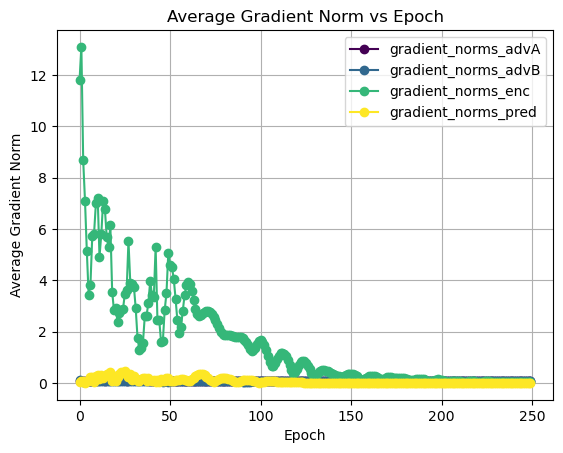

In [70]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

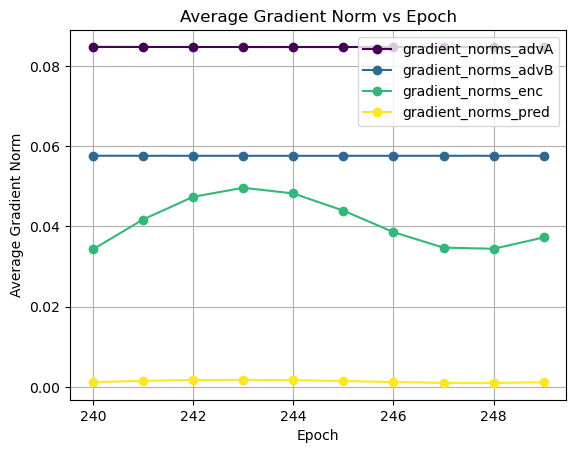

In [71]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advA[-10:], color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advB[-10:], color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_enc[-10:], color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_pred[-10:], color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

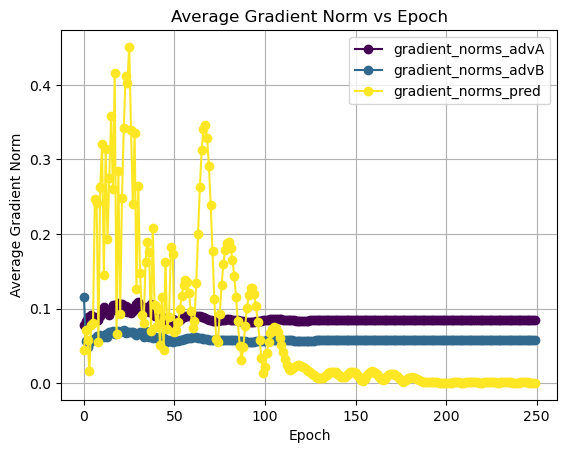

In [72]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
# plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [73]:
# index = 0
# df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
# df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B_Y], axis=1)
# correlation_matrix = df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

In [74]:
index = 0
df_original = datasets[index].copy()

dataset = CustomDataset(df_original)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

encoder_outputs = []
encoder.eval()
with torch.no_grad():
    for batch_X, _ in dataloader:
        output = encoder(batch_X)
        encoder_outputs.append(output)
encoder_outputs = torch.cat(encoder_outputs, dim=0)
print(encoder_outputs.shape)

encoder_outputs_np = encoder_outputs.numpy()
df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B], axis=1)

correlation_matrix = df.corr()

torch.Size([100000, 4])


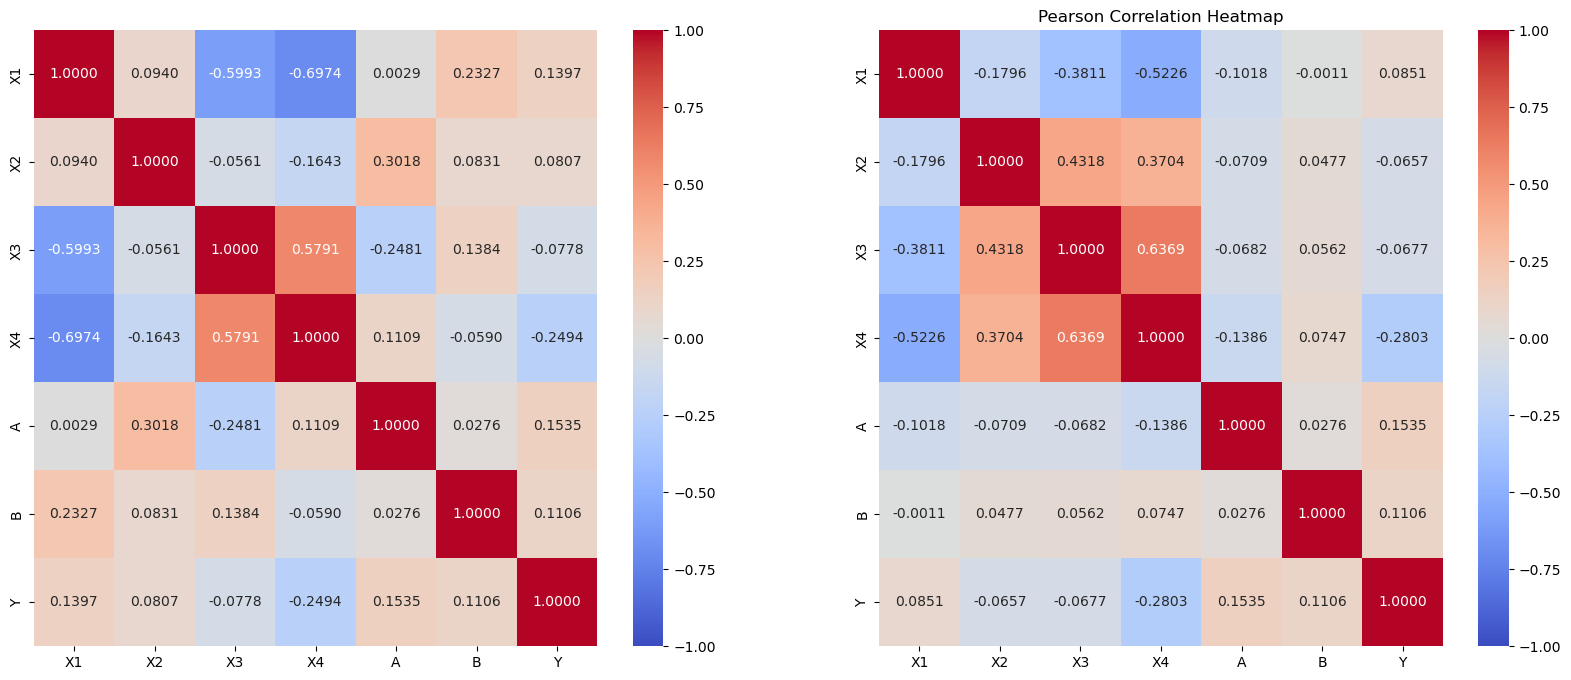

In [44]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

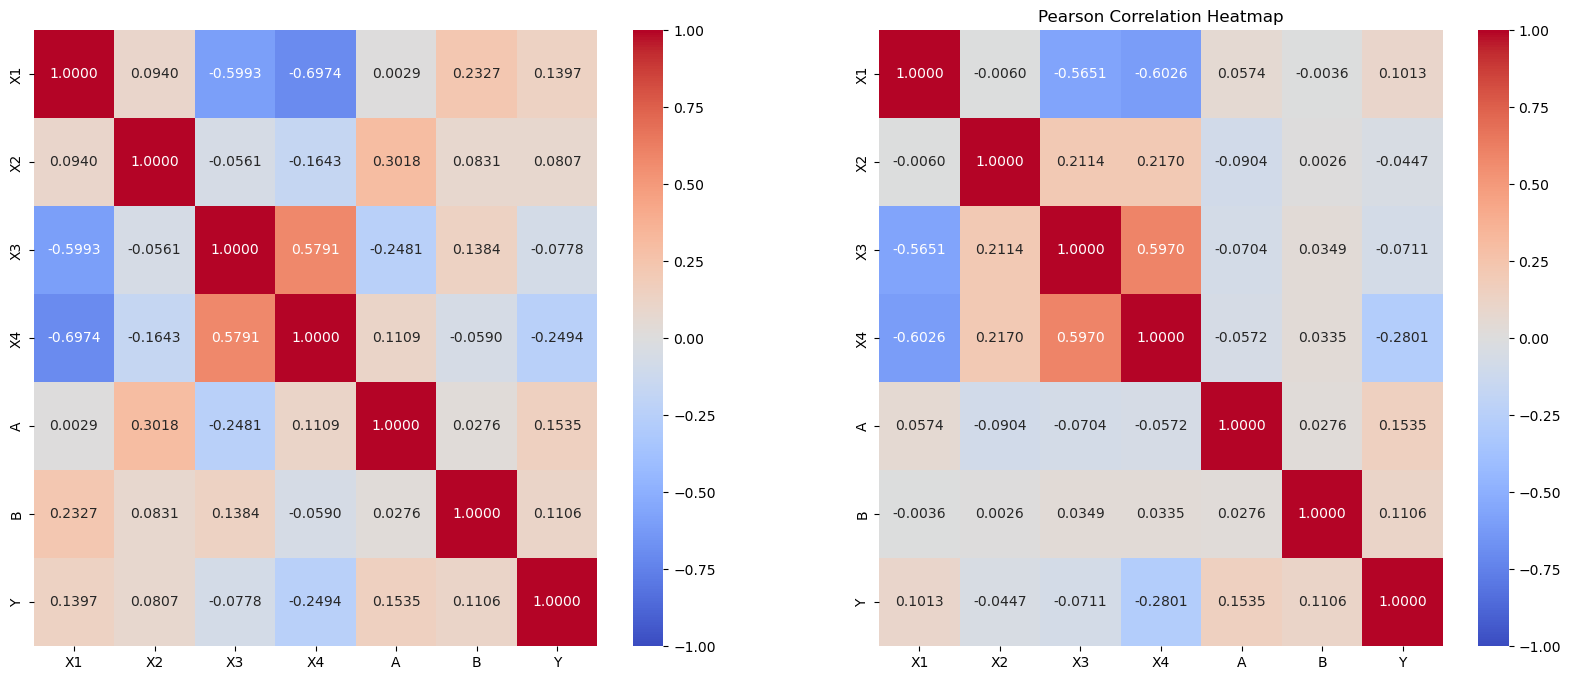

In [52]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

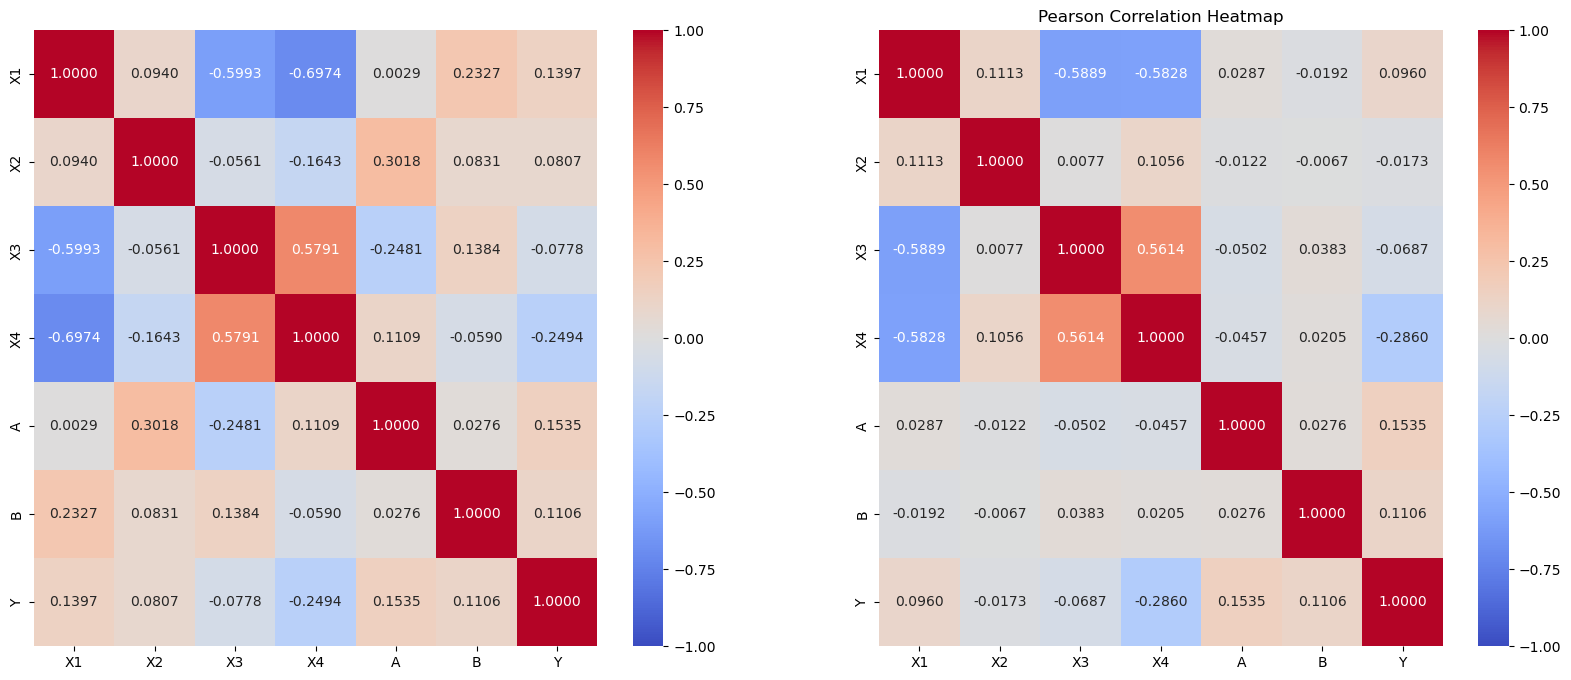

In [59]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

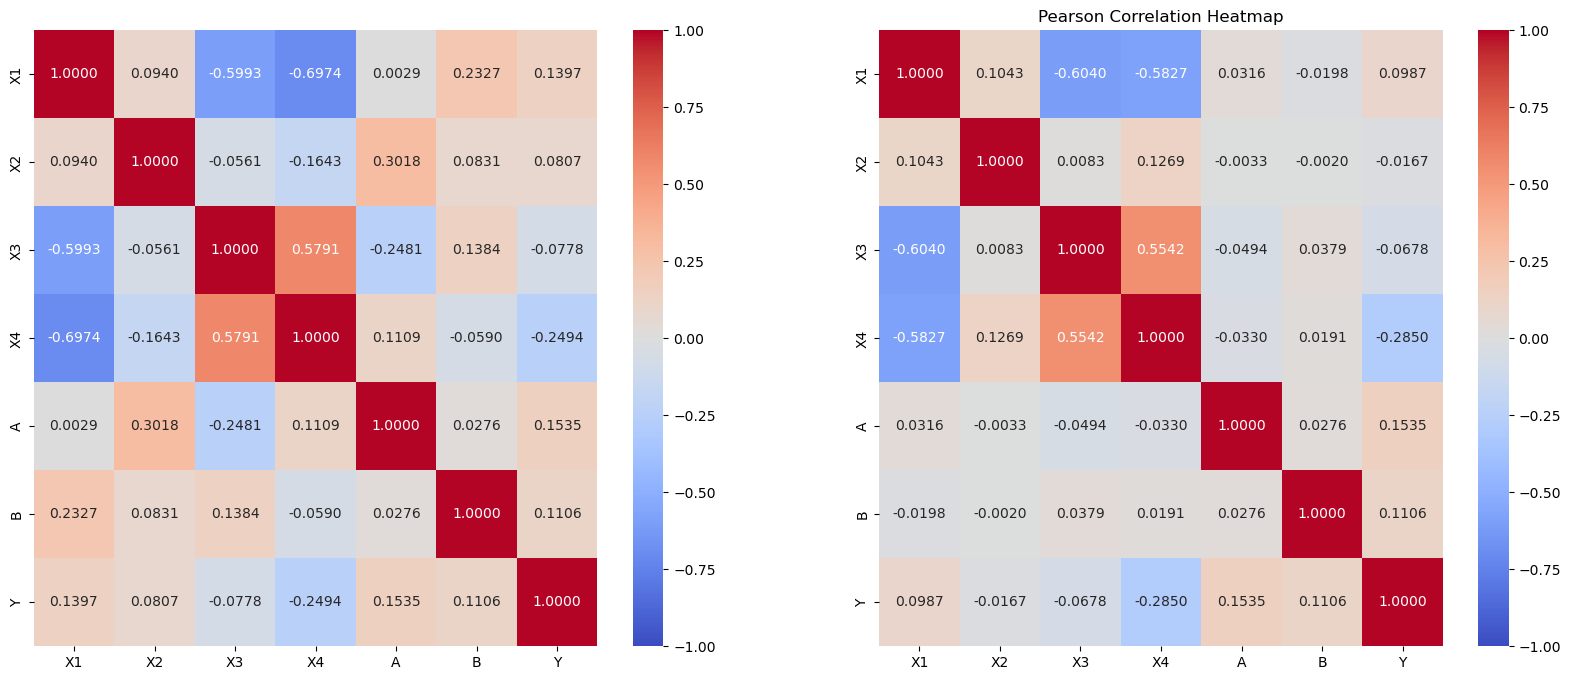

In [67]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

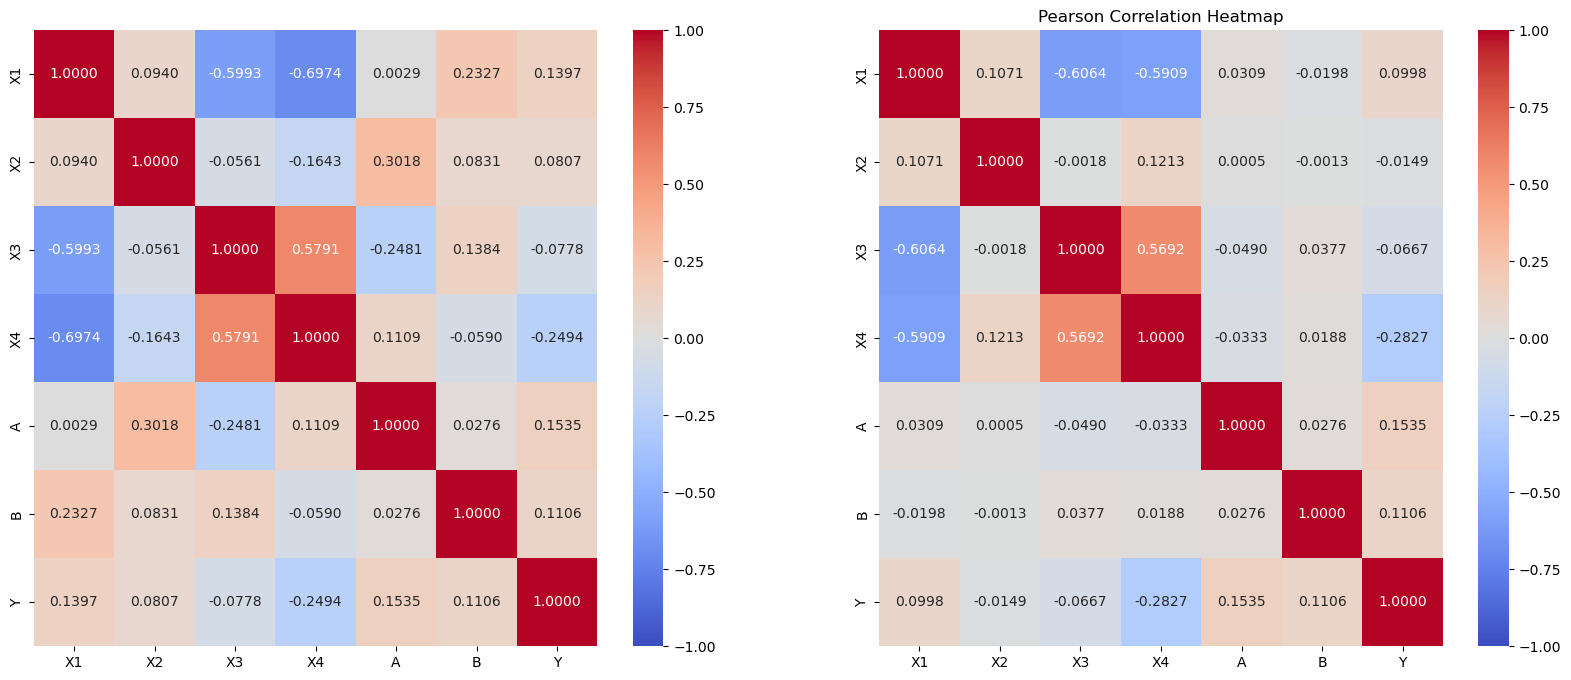

In [75]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [177]:
loss_fn = nn.BCELoss()

In [ ]:
encoder(torch.tenso)
loss_fn()

In [182]:
y = np.random.randint(0,2, size=10000)
y

array([0, 1, 1, ..., 0, 0, 1])

In [184]:
y_hat = 1-y
y_hat

array([1, 0, 0, ..., 1, 1, 0])

In [185]:
from sklearn.metrics import log_loss

In [189]:
log_loss(y,y_hat)

36.043653389117146

In [187]:
log_loss(y,y)

2.2204460492503136e-16